# PDF to Podcast NVIDIA AI Blueprint

Ever wished you could generate podcasts from your own private data? The PDF to podcast NVIDIA AI blueprint makes it possible to build an AI research assistant that creates engaging audio outputs from PDF files. At its core, PDF to podcast is a sophisticated system that:

- Transforms dense PDF documents into natural, engaging conversations
- Creates AI-generated podcasts with either single-speaker or two-person formats
- Uses cutting-edge language models (powered by Llama 3.1-70B NIM, Llama 3.1-8B NIM, and Llama 3.1-405B NIM) to ensure high-quality content
- Leverages ElevenLabs' voice synthesis for natural-sounding audio

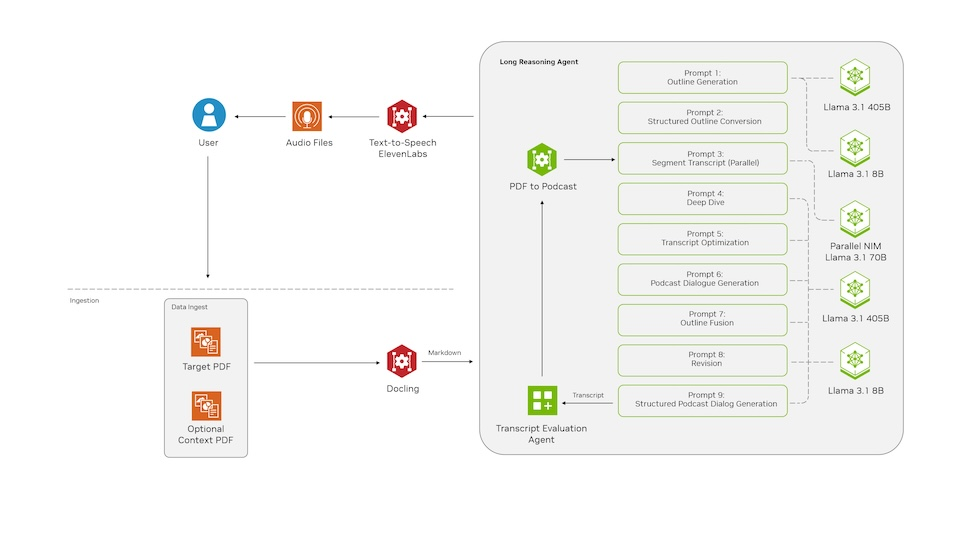


## Features
What sets PDF to podcast apart is its flexible, microservice-driven architecture. Whether you're running on a single machine or a distributed cluster, this blueprint can be adapted to your needs and comes packed with modern tooling and observability features. **We've built this for you to edit and deploy on your own infrastructure with ease.**

#### Observability & Monitoring
- **Jaeger Tracing 🔍** - experience full distributed tracing built in. Watch requests flow through different services and quickly identify bottlenecks in your processing pipeline as you add your own code
- **MinIO Object Storage 📦** - robust, S3-compatible storage for handling PDFs and generated audio content. Perfect for scaling from development to production workloads.
- **GPU Optimized PDF processing 🔥** - use docling for lighting fast optimized PDF processing

#### Development Experience
- **UV Package Management 🚀** - Lightning-fast dependency management using UV, making environment setup a breeze with `make uv`
- **Docker Compose Integration 🐳** - one command (`make all-services`) spins up the entire stack, with smart handling of GPU resources and service dependencies.

#### Quality and Testing
- **Automated Quality Checks ✨** - integrated `ruff` for Python linting and formatting, ensuring consistent code quality across contributions.
- **End-to-End Testing 🧪** - comprehensive test suite for verifying podcast generation, from PDF ingestion to final audio output.

## Prerequisites

### Clone the repository

In [ ]:
!git clone https://github.com/NVIDIA-AI-Blueprints/pdf-to-podcast.git

## Get an NVIDIA NIM Trial API Key

Prior to getting started, you will need to create API Keys to access NVIDIA NIM trial hosted endpoints.

If you don’t have an NVIDIA account, you will be asked to sign-up.

Click [here](https://build.nvidia.com/meta/llama-3_3-70b-instruct?signin=true&api_key=true) to sign-in and get an API key


<div class="alert alert-block alert-success">
    <b>Tip:</b> The key begins with the letters nvapi-.

## Set Environment Variables

This notebook requires certain environment variables to be configured. We'll help you set these up in a `.env` file.

Required variables:
- `ELEVENLABS_API_KEY`: Your ElevenLabs API key
- `NVIDIA_API_KEY`: Your NVIDIA API key
- `MAX_CONCURRENT_REQUESTS`: Number of concurrent requests allowed (recommended: 1 for local development)

> **Note**: While production environments use the NVIDIA Eleven Labs API key which supports concurrent requests, for local development we recommend setting `MAX_CONCURRENT_REQUESTS=1` to avoid rate limiting issues. You can obtain a free testing API key from [ElevenLabs](https://elevenlabs.io).

Run the code cell below to create your `.env` file. Make sure to replace the placeholder values with your actual API keys.

In [ ]:
%%bash

cd pdf-to-podcast/

# Backup existing .env if it exists
if [ -f .env ]; then
    echo "Warning: .env file already exists. Backing up to .env.backup"
    mv .env .env.backup
fi

# Create new .env file
cat > .env << EOL
ELEVENLABS_API_KEY=<ENTER-KEY>
NVIDIA_API_KEY=<ENTER_KEY>
MAX_CONCURRENT_REQUESTS=1
EOL

echo "Created .env file. Please edit it with your actual API keys."
echo -e "\nCurrent .env contents:"
echo "----------------------------------------"
cat .env

## Install Dependancies

We use `uv` to handle the python dependancies for this environment. You can install them by simply running `make uv` in the root of the project

In [ ]:
%%bash

cd pdf-to-podcast/

make uv

## Spin Up Blueprint
Docker compose scripts are provided which spin up the microservices on a single node. This docker-compose yaml file will start up each microservice. This may take up to **15 minutes** to complete.

> **In a separate terminal window, run**

```
cd pdf-to-podcast/
make all-services
```

In [ ]:
!docker ps --format "table {{.ID}}\t{{.Names}}\t{{.Status}}"

This command should produce similiar output in the following format:

```
CONTAINER ID   NAMES                            STATUS
ae5db10fcf7c   pdf-to-podcast-pdf-api-1         Up About a minute
fbc8d417e85c   pdf-to-podcast-api-service-1     Up About a minute
b34b5d64ad4c   pdf-to-podcast-celery-worker-1   Up About a minute
6050545be1e4   pdf-to-podcast-pdf-service-1     Up About a minute
c8cc9253e8a9   pdf-to-podcast-tts-service-1     Up About a minute
5d29deb76eda   pdf-to-podcast-agent-service-1   Up About a minute
1dfc6c61cec9   pdf-to-podcast-minio-1           Up About a minute (healthy)
aa967d41a513   pdf-to-podcast-redis-1           Up About a minute
eb881c33cc64   pdf-to-podcast-jaeger-1          Up About a minute (healthy)
```

You can check if the services are up by running the cells below

In [ ]:
!curl localhost:8002/health

You should get something like 

```
{"status":"healthy","redis":"up","services":{"pdf":"up","agent":"up","tts":"up"},"timestamp":1733295689.5784104}
```

Note: If you are running this as a launchable, you can access the the API endpoint, Jaeger UI, and the MinIO Object Storage UI by going to your running launchable on Brev, clicking `Access`, and clicking the links in the `Deployments` section. It should look like the following: 

<img src="https://github.com/brevdev/notebooks/raw/main/assets/ara-launchable/services.png" />

## Create a podcast!

For this example, we'll directly call the API to generate the podcast. First we write some helper functions to interact with the API

In [5]:
import requests
import json
import time
from typing import List
from IPython.display import Audio
from pathlib import Path

BASE_URL = "http://localhost:8002"

def generate_podcast(
    target_pdf_paths: List[str], 
    name: str,
    duration: int,
    speaker_1_name: str,
    context_pdf_paths: List[str] = None,
    is_monologue: bool = False,
    speaker_2_name: str = None,
    guide: str = None
) -> str:
    """
    Generate a podcast using the API.
    
    Args:
        target_pdf_paths: List of paths to main PDFs to analyze
        name: Name of the podcast
        duration: Desired duration in minutes
        speaker_1_name: Name of the first speaker
        context_pdf_paths: Optional list of paths to context PDFs
        is_monologue: Whether to generate a monologue
        speaker_2_name: Name of second speaker (required if not monologue)
        guide: Optional guidance for the podcast structure
    """
    # Handle single path inputs
    if isinstance(target_pdf_paths, str):
        target_pdf_paths = [target_pdf_paths]
    if isinstance(context_pdf_paths, str):
        context_pdf_paths = [context_pdf_paths]
    
    files = []
    
    # Add all target PDFs
    for pdf_path in target_pdf_paths:
        content = Path(pdf_path).read_bytes()
        files.append(('target_files', (Path(pdf_path).name, content, 'application/pdf')))
    
    # Add all context PDFs if provided
    if context_pdf_paths:
        for pdf_path in context_pdf_paths:
            content = Path(pdf_path).read_bytes()
            files.append(('context_files', (Path(pdf_path).name, content, 'application/pdf')))
    
    # Configure voice mapping
    voice_mapping = {
        "speaker-1": "iP95p4xoKVk53GoZ742B" 
    }
    if not is_monologue:
        voice_mapping["speaker-2"] = "9BWtsMINqrJLrRacOk9x"
    
    # Create parameters
    params = {
        "userId": "test-userid",
        "name": name,
        "duration": duration,
        "monologue": is_monologue,
        "speaker_1_name": speaker_1_name,
        "voice_mapping": voice_mapping,
        "guide": guide,
        "vdb_task": False
    }
    if not is_monologue:
        params["speaker_2_name"] = speaker_2_name
    
    response = requests.post(
        f"{BASE_URL}/process_pdf", 
        files=files,
        data={'transcription_params': json.dumps(params)}
    )
    if response.status_code != 202:
        raise Exception(f"Failed to submit podcast generation: {response.text}")
    
    return response.json()['job_id']

def get_status(job_id: str) -> dict:
    """Get the current status of all services for a job."""
    response = requests.get(f"{BASE_URL}/status/{job_id}?userId=test-userid")
    if response.status_code != 200:
        raise Exception(f"Failed to get status: {response.text}")
    return response.json()

def wait_for_completion(job_id: str, check_interval: int = 5, initial_delay: int = 10):
    """
    Poll the status endpoint until the podcast is ready.
    Shows a simplified progress view.
    """
    print(f"Waiting {initial_delay} seconds for job to initialize...")
    time.sleep(initial_delay)
    
    last_messages = {}  # Track last message for each service to avoid duplication
    
    while True:
        try:
            statuses = get_status(job_id)
            
            # Check each service and only print if status changed
            for service, status in statuses.items():
                current_msg = status.get('message', '')
                if current_msg != last_messages.get(service):
                    print(f"[{service.upper()}] {current_msg}")
                    last_messages[service] = current_msg
            
            # Check if everything is completed
            all_completed = all(
                status.get('status') == 'JobStatus.COMPLETED' 
                for status in statuses.values()
            )
            
            if all_completed and 'tts' in statuses:
                print("\nPodcast generation completed!")
                return
            
            # Check for failures
            for service, status in statuses.items():
                if status.get('status') == 'JobStatus.FAILED':
                    raise Exception(f"Service {service} failed: {status.get('message')}")
            
            time.sleep(check_interval)
            
        except requests.exceptions.RequestException as e:
            if "Job not found" in str(e):
                print("Waiting for job to start...")
                time.sleep(check_interval)
                continue
            raise
        except Exception as e:
            print(f"Error: {e}")
            raise

Next you will generate a monologue using various analyst reports on NVIDIAs most recent financial earnings. You can also add your own PDFs to this Jupyter Lab and point to them in code below. Note that context PDFs are optional and can be used to provide additional context for the generation process. Additonally, you can provide a `guide` to help guide the generation process.

In [ ]:
try:
    print("Submitting podcast generation request...")
    job_id = generate_podcast(
        target_pdf_paths=[
            "pdf-to-podcast/samples/investorpres-main.pdf",
        ],
        context_pdf_paths=[
            "pdf-to-podcast/samples/bofa-context.pdf",
            "pdf-to-podcast/samples/citi-context.pdf"
        ],
        name="NVIDIA Earnings Analysis",
        duration=15,
        speaker_1_name="Alex",
        is_monologue=True,
        guide="Focus on NVIDIA's earnings and the key points driving it's growth"
    )
    print(f"Job ID: {job_id}")
    wait_for_completion(job_id)
except Exception as e:
    print(f"Error: {e}")

You can also generate a 2 person podcast by calling the same function but setting `is_monologue=False` and providing a `speaker_2_name`.

In [ ]:
!curl "localhost:8002/output/{job_id}?userId=test-userid" --output temp_audio.mp3
Audio("temp_audio.mp3")

## Understanding Your Generated Podcast

After generating your podcast, you have access to a couple valuable outputs that provide insights into the generation process and content. Here's what endpoints you can use to explore:

#### 1. The Transcript
```python
/saved_podcast/{job_id}/transcript"
```

The transcript provides a text version of your podcast, which is valuable for:
- Quick content review without audio playback
- Creating show notes or content summaries
- Finding and quoting specific discussion points
- Making content searchable and referenceable
- Ensuring accessibility of your content

In [ ]:
!curl "localhost:8002/saved_podcast/{job_id}/transcript?userId=test-userid"

#### 2. Prompt and Generation History
```python
/saved_podcast/{job_id}/history
```

The history reveals the AI's thought process, showing you:
- How the system analyzed and interpreted your PDFs
- Key topics and themes identified
- The structural decisions made for the conversation
- The reasoning behind content organization
- How different sections were prioritized and connected

This is particularly useful for:
- Understanding how the AI makes decisions
- Improving future podcast generations
- Verifying content accuracy and relevance
- Fine-tuning and evals on your prompts

In [ ]:
!curl "localhost:8002/saved_podcast/{job_id}/history?userId=test-userid"

In [ ]:
!curl "localhost:8002/saved_podcast/{job_id}/metadata?userId=test-userid"

### Tools for Understanding Your Generated Podcast

After generating your podcast, you can explore the generation process through several tools:

#### 1. Jaeger Tracing Interface
Access Jaeger at `localhost:16686` to:
- Visualize the complete request flow
- Debug processing bottlenecks
- Monitor service performance
- Track PDF processing and audio generation stages

#### 2. MinIO Object Storage
Access MinIO at `localhost:9001` with:
```
Username: minioadmin
Password: minioadmin
```
Here you can:
- Browse generated audio files
- Access intermediate processing artifacts
- View stored PDF documents
- Download or share content via presigned URLs

#### 3. API Endpoints
You can access the API endpoint at `localhost:8002/docs`.

> **Note**: If you are running this as a Brev launchable, you can access the the API endpoint, Jaeger UI, and the MinIO Object Storage UI by going to your running launchable on Brev, clicking `Access`, and clicking the links in the `Deployments` section. It should look like the following: 

<img src="https://github.com/brevdev/notebooks/raw/main/assets/ara-launchable/services.png" />